# Eigenfaces

This optional assignment is an application of principal components analysis (PCA) and k-means to the analysis of "familiar faces." You'll also create a simple interactive visualization for exploring this dataset.

You'll need a bunch of modules, so let's load those first.

In [1]:
# Some standard modules

import os
import sys
import re

import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [2]:
# Modules for loading and transforming images

from PIL import Image
import base64
from io import BytesIO

def to_base64(png):
    return "data:image/png;base64," + base64.b64encode(png).decode("utf-8")

In [3]:
# For creating an interactive visualization

import bokeh
from bokeh.io import output_notebook
output_notebook ()
print ("Bokeh version:", bokeh.__version__)

from bokeh.palettes import brewer

def make_color_map (values):
    """Given a collection of discrete values, generate a color map."""
    unique_values = np.unique (values) # values must be discrete
    num_unique_values = len (unique_values)
    min_palette_size = min (brewer['Set1'].keys ())
    max_palette_size = max (brewer['Set1'].keys ())
    assert num_unique_values <= max_palette_size
    palette = brewer['Set1'][max (min_palette_size, num_unique_values)]
    color_map = dict (zip (unique_values, palette))
    return color_map

Loading BokehJS ...

Bokeh version: 0.12.14


In [4]:
# This cell defines a function to make an interactive scatter plot of thumbnail images.

## http://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#userguide-tools-inspectors
from bokeh.io import show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import PanTool, BoxZoomTool, HoverTool, CrosshairTool, ResetTool

def make_scatter2d_images(x, y, names=None, image_files=None, clustering=None):
    source_data = dict(x=x, y=y)
    if names is not None:
        source_data["desc"] = names
        tooltips_desc = """<span style="font-size: 17px; font-weight: bold;">@desc</span>"""
    else:
        tooltips_desc = ""
        
    if image_files is not None:
        source_data["imgs"] = image_files
        tooltips_images = """
            <div>
                <img
                    src="@imgs" height="42" alt="@imgs" width="42"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
        """
    else:
        tooltips_images = ""
        
    if clustering is not None:
        color_map = make_color_map(clustering)
        cluster_colors = [color_map[c] for c in clustering]
        source_data['cluster_color'] = cluster_colors

    source = ColumnDataSource(data=source_data)
    hover = HoverTool(tooltips="""
        <div>
            {}
            <div>
                {}
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """.format(tooltips_images, tooltips_desc))

    p = figure(width=600, height=600)
    for t in [PanTool(), BoxZoomTool(), hover, CrosshairTool(), ResetTool()]:
        p.add_tools(t)
    
    if clustering is not None:
        p.circle(x='x', y='y',
                 fill_color='cluster_color',
                 line_color='cluster_color',
                 size=5, source=source)
    else:
        p.circle(x='x', y='y', size=5, source=source)
    return p

## Recap: Solving the PCA problem

Recall the basic algorithm to compute a PCA and the interactive visual demo of which appears at http://setosa.io/ev/principal-component-analysis/.

You are given a set of $m-1$ data points or observations, $X \equiv (\hat{x}_0, \hat{x}_1, \cdots, \hat{x}_{m-1})^T$. Each observation consists of $d$ measured predictors, which we represent by the $d$-dimensional vector $x_i \in \mathbb{R}^d$. You wish to find a $k$-dimensional representation of these points, where $k \leq s \equiv \min{m, d}$. To do so, you run the PCA procedure, which identifies a $k$-dimensional subspace in terms of $k$ orthogonal vectors ("axes"); these vectors are the _principal components_.

1. If the data are not centered, transform them accordingly. In particular, ensure that their mean is 0, i.e., $\displaystyle \frac{1}{m} \sum_{i=0}^{m-1} \hat{x}_i = 0$.
2. Compute the $k$-truncated SVD, $X \approx U_k \Sigma_k V_k^T$. The truncated SVD is just the subset of singular vectors corresponding to the largest $k$ singular values.
3. Choose $v_0, v_1, \ldots, v_{k-1}$ as the principal components.

## The dataset: Some familiar faces

The data set for this notebook is a bunch of images of people's faces. These are preloaded for those of you on either the Vocareum or Azure Notebooks platform.

In [5]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def on_azure():
    return 'AZURE_NOTEBOOKS_VMVERSION' in os.environ

def on_vuduc_box():
    return os.uname().nodename in ['daffy5.lan', 'insomnia']
    
if on_vocareum():
#    DATA_PATH, IMAGE_EXT = "../resource/asnlib/publicdata/lfwcrop_grey/faces/", "pgm"
    DATA_PATH, IMAGE_EXT = "../resource/asnlib/publicdata/att_faces/", "pgm"
#    DATA_PATH, IMAGE_EXT = "../resource/asnlib/publicdata/mit_faces/", "png"
elif on_azure() or on_vuduc_box():
#    DATA_PATH, IMAGE_EXT = "peeps/", "png"
    DATA_PATH, IMAGE_EXT = "peeps_all/", "tiff"
else:
    print("""
*** Unrecognized platform ***

You will need to manually download a faces dataset and modify
this code cell to point to it by setting the `DATA_PATH` and
`IMAGE_EXT` variables, below.

Some options include:

* The MIT Faces Recognition Project database:
  http://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/
  
* The AT&T Faces database, which has images in PGM format ('pgm' extensions):
  http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
  
* The LFWcrop database, which has images in PGM format ('pgm' extensions):
  http://conradsanderson.id.au/lfwcrop/
    """)
    DATA_PATH = None  # Path to image dataset
    IMAGE_EXT = None  # Image file extension

assert os.path.exists(DATA_PATH), "Where are the images?"
print("Will look for images having a '.{}' extension in '{}'.".format(IMAGE_EXT, DATA_PATH))

Will look for images having a '.pgm' extension in '../resource/asnlib/publicdata/att_faces/'.


To view these images, our standard procedure will be to convert them to grayscale first and then maintain them in 2-D Numpy arrays. We will use the following helper functions for this purpose.

In [6]:
def im2gnp(image):
    """Converts a PIL image into an image stored as a 2-D Numpy array in grayscale."""
    return np.array(image.convert ('L'))

def gnp2im(image_np):
    """Converts an image stored as a 2-D grayscale Numpy array into a PIL image."""
    return Image.fromarray(image_np.astype(np.uint8), mode='L')

def imshow_gray(im, ax=None):
    if ax is None:
        f = plt.figure()
        ax = plt.axes()
    ax.imshow(im,
              interpolation='nearest',
              cmap=plt.get_cmap('gray'))

Next, let's load all the images as grayscale into a list of Numpy arrays, `original_images`, along with an array `image_names` to hold a name for each image. (The names are extracted from the image filename.)

The following two code cells proceed in two steps. The first gathers a list of all valid image filenames. The second loads them. If there are "too many" images, defined by a threshold that you can change if you are willing to wait longer, the second cell will also randomly select a subset to load.

In [7]:
# Collect list of valid image filenames
image_file_list = []
image_name_list = {}
for base, dirs, files in os.walk(DATA_PATH):
    for filename in files:
        name_ext = re.match (r'^(.*)\.{}$'.format(IMAGE_EXT), filename)
        if name_ext:
            filepath = os.path.join(base, filename)
            image_file_list.append(filepath)
            image_name_list[filepath] = name_ext.groups(0)[0]
print("Found {} images in total.".format(len(image_file_list)))

Found 400 images in total.


In [8]:
# Load up to `MAX_IMAGES` of the available images
MAX_IMAGES = 500

if len(image_file_list) > MAX_IMAGES:
    images_to_load = np.random.choice(image_file_list, size=MAX_IMAGES, replace=False)
else:
    images_to_load = image_file_list

original_images = []
image_names = []
for filepath in images_to_load:
    try:
        im = im2gnp(Image.open(filepath, 'r'))
        key = image_name_list[filepath]
        original_images.append(im)
        image_names.append(key)
    except OSError:
        print("WARNING: Could not recognize or open '{}'...".format(filepath))
        pass
            
print("Loaded", len(original_images), "images.\n")

Loaded 400 images.



## Preprocessing the images

To apply PCA, we'll want to preprocess the images in various ways.

To begin with, it's possible that that the images come in all shapes and sizes. The following code will figure out what is the largest height and width that are within the bounds of all the images.

In [9]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for (i, image) in enumerate(original_images):
    r, c = image.shape[0], image.shape[1]    
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)
    
print("\n==> Least common image size:", min_rows, "x", min_cols, "pixels")


==> Least common image size: 112 x 92 pixels


**Exercise 0** (2 points). Suppose the least common image size is $r_0 \times c_0$ pixels is the smallest dimension. Crop each $r \times c$ image so that it is $r_0 \times c_0$ in size. If $r > r_0$, then crop out any extra rows on the **bottom** of the image; and if $c > c_0$, then center the columns of the image. Store the output images in a **3-D** Numpy array called `images[:, :, :]`, where `images[k, :, :]` is the `k`-th image.

4 -- Recentering: Before = 112 x 92 pixels; after = 112 x 92 pixels.


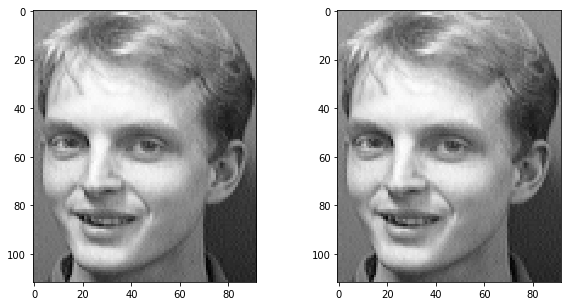

In [10]:
def recenter(image, min_rows, min_cols):
    r, c = image.shape
    
    # Compute four variables, `top`, `left`, `bot`,
    # and `right` so that the `return` statement
    # returns the recentered image.
    
    top = 0
    left = int((c - min_cols) / 2)
    bot = top + min_rows
    right = left + min_cols
    
    return image[top:bot, left:right]

# Quick test
image0 = original_images[0]

print("{} -- Recentering: Before = {} x {} pixels; after = {} x {} pixels.".format(image_names[0],
                                                                                   image0.shape[0],
                                                                                   image0.shape[1],
                                                                                   min_rows, min_cols))
image0_recentered = recenter(image0, min_rows, min_cols)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
imshow_gray(image0, ax=axs[0])
imshow_gray(image0_recentered, ax=axs[1])

In [11]:
# Test cell: `recenter_test`

# Re-center images to a common size
images_recentered = np.zeros((len(original_images), min_rows, min_cols))
for (k, image) in enumerate(original_images):
    images_recentered[k, :, :] = recenter(image, min_rows, min_cols)
    
print("\n(Passed!)")


(Passed!)


**Aside: Generating thumbnails.** The latter part of this notebook creates an interactive visualization, for which we will need thumbnail versions of these images. The following code creates those thumbnails. It stores them as a list, `thumbnails[:]`, of Base64-encoded binary `PNG` data, which can be embedded directly into HTML.

In [12]:
thumbnails = []
for gnp in images_recentered:
    im = gnp2im(gnp)
    memout = BytesIO()
    im.save(memout, format='png')
    thumbnails.append(to_base64(memout.getvalue()))

**Exercise 1** (2 points). Compute an "average" image, taken as the elementwise (pixelwise) mean over all images. Store the result in a `min_rows` $\times$ `min_cols` Numpy array called, `mean_image`.

> The cell will display this "average face." How would you describe it?

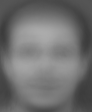

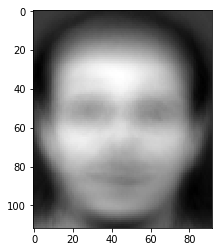

In [13]:
# Store your result in a variable called `mean_image`
mean_image = np.mean(images_recentered, axis=0)
    
# Display the "average" face
imshow_gray(mean_image)
gnp2im(mean_image)

**Exercise 2** (2 points). Recall that PCA requires centered points. Let's do that by subtracting the mean image from every image. Use the recentered images computed in one of the above tests (`images_recentered`) and store the result in a new array, `images`.

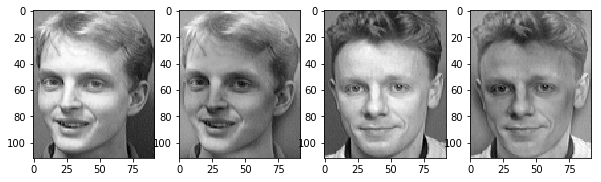

In [14]:
images = images_recentered - mean_image


f, axs = plt.subplots(1, 4, figsize=(10, 40))
imshow_gray(images[0, :, :] + mean_image, ax=axs[0])
imshow_gray(images[0, :, :], ax=axs[1]) # Compare this to the original.
imshow_gray(images[-1, :, :] + mean_image, ax=axs[2])
imshow_gray(images[-1, :, :], ax=axs[3]) # Compare this to the original.

In [15]:
# Test cell: `sub_mean_test`

max_abs_sum = np.max(np.abs((np.sum(images, axis=0))))
max_abs_sum_bound = np.finfo(float).eps * (len(images)**2) * np.max(images)
print(max_abs_sum, "<=", max_abs_sum_bound, "?")
assert max_abs_sum <= max_abs_sum_bound

5.5294435696850996e-11 <= 6.284572862114146e-09 ?


## From image set to a data matrix and back again

For PCA, you need a data matrix. Here is some code to convert our 3-D array of images into a 2-D data matrix, where we "flatten" each image into a 1-D vector by a simple `reshape()` operation.

In [16]:
# Create m x d data matrix
m = len(images)
d = min_rows * min_cols
X = np.reshape(images, (m, d))

4


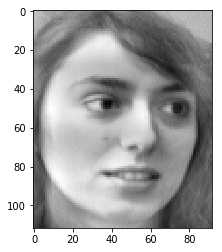

In [17]:
# To get back to an image, just reshape it again
imshow_gray(np.reshape(X[int(len(X)/2), :], (min_rows, min_cols)))
print(image_names[int(len(X)/2)])

## Applying PCA

**Exercise 3** (2 points). Compute the SVD of `X`. Store the result in three arrays, `U`, `Sigma`, and `VT`, where `U` holds $U$, `Sigma` holds just the diagonal entries of $\Sigma$, and `VT` holds $V^T$.

In [18]:
(U, Sigma, VT) = np.linalg.svd(X, full_matrices=False)


In [19]:
# Sanity check on dimensions
print("X:", X.shape)
print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("V^T:", VT.shape)

assert X.shape == (len(images), min_rows * min_cols)

s = min(X.shape)
assert U.shape == (len(images), s)
assert Sigma.shape == (s,)
assert VT.shape == (s, min_rows * min_cols)

X: (400, 10304)
U: (400, 400)
Sigma: (400,)
V^T: (400, 10304)


The following code inspects the singular values, i.e., the entries of $\Sigma$ stored in `Sigma`. The plot will show the singular values as dots, plotted at each position $x=i$ for the $i$-th singular values. To give you a rough idea of how quickly the singular values decay, the plot includes a solid line showing the curve, $\frac{\sigma_0}{\sqrt{i+1}}$.

Singular values:


,i,sigma_i,sigma_i^2,err_i^2,err_i,relerr_i
0,0,33566.949753,1.126740e+09,5.271721e+09,72606.615042,0.683848
1,1,28737.189229,8.258260e+08,4.445895e+09,66677.541219,0.628005
2,2,20921.792714,4.377214e+08,4.008173e+09,63310.134202,0.596289
3,3,18893.556131,3.569665e+08,3.651207e+09,60425.215179,0.569117
4,4,18081.917849,3.269558e+08,3.324251e+09,57656.316881,0.543038


  ...


,i,sigma_i,sigma_i^2,err_i^2,err_i,relerr_i
395,395,7.018437e+02,4.925846e+05,1.332882e+06,1154.505265,1.087375e-02
396,396,6.916698e+02,4.784072e+05,8.544752e+05,924.378304,8.706294e-03
397,397,6.583788e+02,4.334626e+05,4.210126e+05,648.854859,6.111266e-03
398,398,6.488549e+02,4.210126e+05,2.861023e-06,0.001691,1.593105e-08
399,399,1.195803e-11,1.429944e-22,2.861023e-06,0.001691,1.593105e-08


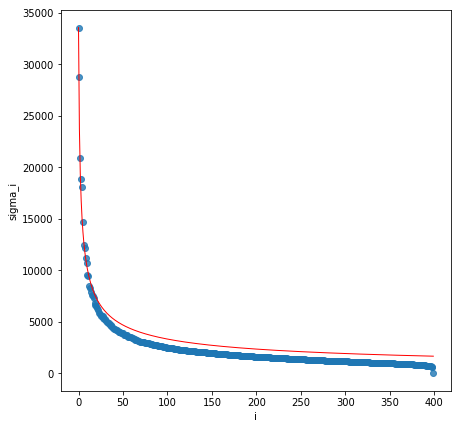

In [20]:
def peek_Sigma (Sigma, ret_df=False):
    k = len (Sigma)
    df_Sigma = pd.DataFrame()
    df_Sigma['i'] = np.arange(k)
    df_Sigma['sigma_i'] = Sigma
    Sigma_sq = np.power (Sigma, 2)
    Err_sq = np.sum(Sigma_sq) - np.cumsum(Sigma_sq)
    Err_sq[Err_sq < 0] = 0
    Err = np.sqrt(Err_sq)
    Relerr = Err / (Sigma[0] + Err[0])
    df_Sigma['sigma_i^2'] = Sigma_sq
    df_Sigma['err_i^2'] = Err_sq
    df_Sigma['err_i'] = Err
    df_Sigma['relerr_i'] = Relerr
    print("Singular values:")
    display(df_Sigma.head())
    print("  ...")
    display(df_Sigma.tail())
    
    f, ax = plt.subplots (figsize=(7, 7))
    #ax.set (yscale="log")
    sns.regplot("i", "sigma_i", df_Sigma, ax=ax, fit_reg=False)
    if ret_df:
        return df_Sigma
    
df_Sigma = peek_Sigma(Sigma, ret_df=True)

# Adds a red line to the plot: y ~ sigma_0 / sqrt(i+1)
plt.plot(df_Sigma['i'], df_Sigma['sigma_i'][0]*np.power(df_Sigma['i']+1, -0.5),
         color="red", linewidth=1)

**Exercise 4** (ungraded). Does the spectrum of these data decay quickly or slowly? How should that affect your choice of $k$, if you are considering a $k$-truncated SVD?

**Answer.** The question is ill-defined and the answer is relative. In this case, a reasonable argument is that the spectrum actually decays somewhat slowly. Why? If you try fitting the singular values $\{\sigma_i\}$ to functions of $i$, you'll find that $\frac{1}{\sqrt{i+1}}$ is actually a pretty good fit. That is considered fairly slow decay; there would be significant compressibility if the curve dropped off exponentially (or at least superlinearly) instead.

Next, let's plot the first few principal components. From what you computed above, each right singular vector has the same number of entries as there are pixels in an image. So, we could plot them as images by reshaping them. What do they appear to capture?

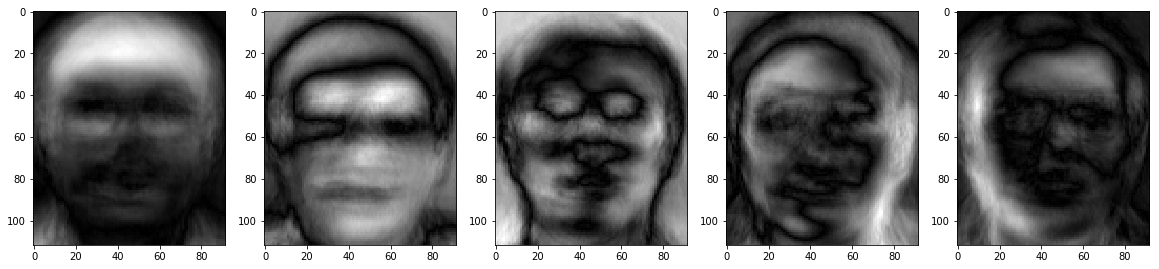

In [21]:
k_plot = 5
fig, axs = plt.subplots(1, k_plot, figsize=(20, 60))
for k_i in range(k_plot):
    vector_as_image = np.reshape(np.abs(VT[k_i, :]), (min_rows, min_cols))
    imshow_gray(vector_as_image, ax=axs[k_i])

**Exercise 5** (2 points). Write some code to compute a new matrix `Y`, which is the original data matrix projected onto the first `num_components` principal components.

> You can use the code cell below, which calls `make_scatter2d_images`, to create an interactive plot of your projection. Does it reveal any interesting groupings?

In [24]:
num_components = 5 # Number of principal components

# Define `Y`:
Y = X.dot(VT[:num_components, :].T)

p = make_scatter2d_images(Y[:, 0], Y[:, 1], # Try plotting different axes
                          names=image_names,
                          image_files=thumbnails)
show(p)

In [25]:
# Test cell: `Y_test`

assert Y.shape == (len(X), num_components)
print("\n('Passed' -- not really checking anything...)")


('Passed' -- not really checking anything...)


**Exercise 6** (2 points). Run $k$-means on the projected data, `Y[:m, :num_components]`, to try to identify up to `num_clusters` clusters. Store the cluster centers in an array `centers[:num_clusters, :2]` and the cluster labels in an array `clustering[:m]`.

> You may use Scipy's `kmeans()` routine.

In [ ]:
from scipy.cluster.vq import kmeans, vq

num_clusters = 3 # Try changing this value

centers, distortion = kmeans(Y, num_clusters)
clustering, _ = vq(Y, centers)
print(centers)

p = make_scatter2d_images(Y[:, 0], Y[:, 1], # Try plotting different axes
                          names=image_names,
                          image_files=thumbnails,
                          clustering=clustering)
show(p)

[[-1343.90952039  -671.32327721   702.6106653    -10.81827564
   -178.37537152]
 [ -728.29202982  1230.21529033  -824.24232768   102.21234862
    377.61068936]
 [ 1771.97990781  -326.29718264   -10.60950083   -67.87281504
   -125.2571204 ]]


In [ ]:
# Test cell: `run_kmeans_test`

df_kcurve = pd.DataFrame (columns=['k', 'distortion']) 
for i in range(1,10):
    _, distortion = kmeans(Y, i)
    df_kcurve.loc[i] = [i, distortion]
df_kcurve.plot(x="k", y="distortion")

print("\n('Passed' -- not really checking anything...)")

## References

Today's notebook uses a bunch of library modules and coding tricks; if you want to learn more, see these references.

_Image manipulation_
* Working with TIFFs: http://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy
* Displaying PIL images inline: http://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
* Convert to grayscale: http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

_PCA in Python_
* http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html